# DAT210x - Programming with Python for DS

## Module5- Lab6

In [1]:
import random, math
import pandas as pd
import numpy as np
import scipy.io

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot') # Look Pretty

from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA


from sklearn.neighbors import KNeighborsClassifier
# Leave this alone until indicated:
Test_PCA = False

### A Convenience Function

This method is for your visualization convenience only. You aren't expected to know how to put this together yourself, although you should be able to follow the code by now:

In [2]:
def plot_2d_boundary(model, d_train, l_train, d_test, l_test):
    fig, ax = plt.subplots()
    ax.set_title('Transformed Boundary, Image Space -> 2D')
    padding = 0.1
    resolution = 1
    # Calculate the boundaries of the mesh grid:
    ranges = np.ptp(d_train, axis=0)
    x_max, y_max = np.max(d_train, axis=0) + ranges * padding
    x_min, y_min = np.min(d_train, axis=0) - ranges * padding
    # Make the 2D Grid Matrix:
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    # Plot the mesh grid:
    ax.contourf(xx, yy, pred, alpha=.5, cmap='viridis')
    # Plot the test images:
    for n in range(d_test.shape[0]):
        # Set image shape:
        x0, y0 = d_test[n] - ranges * 0.025
        x1, y1 = d_test[n] + ranges * 0.025
        # Plot the image:
        img = pics[l_test.index[n], :].reshape(num_pixels, num_pixels)
        ax.imshow(img, aspect='auto', interpolation='nearest', zorder=100000,
                  extent=(x0, x1, y0, y1), cmap='gray', alpha=.8)
    # Plot the train data:
    ax.scatter(d_train[:, 0], d_train[:, 1], c=l_train, cmap='viridis',
               alpha=.8, marker='o', edgecolors='black')
    # Show graph:
    plt.show()


### The Assignment

Use the same code from Module4/assignment4.ipynb to load up the `face_data.mat` file into a dataframe called `df`. Be sure to calculate the `num_pixels` value, and to rotate the images to being right-side-up instead of sideways. This was demonstrated in the [Lab Assignment 4](https://github.com/authman/DAT210x/blob/master/Module4/assignment4.ipynb) code.

In [3]:
mat = scipy.io.loadmat('datasets/face_data.mat')
pics = mat['images'].transpose()
num_images = pics.shape[0]
num_pixels = int(np.sqrt(pics.shape[1]))
#The .shape attribute for numpy arrays returns the dimensions of the array. 
#If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
# Transpose the pictures:
for i in range(num_images):
    pics[i, :] = pics[i, :].reshape(num_pixels,num_pixels).transpose().flatten()
    
pics

array([[ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01617647,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Load up your face_labels dataset. It only has a single column, and you're only interested in that single column. You will have to slice the  column out so that you have access to it as a "Series" rather than as a "Dataframe". This was discussed in the the "Slicin'" lecture of the  "Manipulating Data" reading on the course website. Use an appropriate indexer to take care of that. Be sure to print out the labels and compare what you see to the raw `face_labels.csv` so you know you loaded it correctly.

In [4]:
labels = pd.read_csv('datasets/face_labels.csv', header=None)[0]
labels.head()

0    0
1    2
2    0
3    2
4    0
Name: 0, dtype: int64

Do `train_test_split`. Use the same code as on the EdX platform in the reading material, but set the random_state=7 for reproducibility, and the test_size to 0.15 (150%). Your labels are actually passed in as a series (instead of as an NDArray) so that you can access their underlying indices later on. This is necessary so you can find your samples in the original dataframe. The convenience methods we've written for you that handle drawing expect this, so that they can plot your testing data as images rather than as points:

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(pics, labels, test_size=.15, random_state=7) 


### Dimensionality Reduction

In [6]:
if Test_PCA:
    # INFO: PCA is used *before* KNeighbors to simplify your high dimensionality
    # image samples down to just 2 principal components! A lot of information
    # (variance) is lost during the process, as I'm sure you can imagine. But
    # you have to drop the dimension down to two, otherwise you wouldn't be able
    # to visualize a 2D decision surface / boundary. In the wild, you'd probably
    # leave in a lot more dimensions, which is better for higher accuracy, but
    # worse for visualizing the decision boundary;
    #
    # Your model should only be trained (fit) against the training data (data_train)
    # Once you've done this, you need use the model to transform both data_train
    # and data_test from their original high-D image feature space, down to 2D


    # TODO: Implement PCA here. ONLY train against your training data, but
    # transform both your training + test data, storing the results back into
    # data_train, and data_test.
    
    pca = PCA(n_components = 2)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    #X_train = pca.fit_transform(X_train) ALTERNATIVE FIT& TRANSFORM IN 1

else:
    # INFO: Isomap is used *before* KNeighbors to simplify your high dimensionality
    # image samples down to just 2 components! A lot of information has been is
    # lost during the process, as I'm sure you can imagine. But if you have
    # non-linear data that can be represented on a 2D manifold, you probably will
    # be left with a far superior dataset to use for classification. Plus by
    # having the images in 2D space, you can plot them as well as visualize a 2D
    # decision surface / boundary. In the wild, you'd probably leave in a lot more
    # dimensions, which is better for higher accuracy, but worse for visualizing the
    # decision boundary;
    
    # Your model should only be trained (fit) against the training data (data_train)
    # Once you've done this, you need use the model to transform both data_train
    # and data_test from their original high-D image feature space, down to 2D

    
    # TODO: Implement Isomap here. ONLY train against your training data, but
    # transform both your training + test data, storing the results back into
    # data_train, and data_test.
    #from sklearn.manifold import Isomap
    iso = Isomap(n_neighbors = 5, n_components = 2)
    iso.fit(X_train)
    X_train = iso.transform(X_train)
    X_test = iso.transform(X_test)


Implement `KNeighborsClassifier` here. You can use any K value from 1 through 20, so play around with it and attempt to get good accuracy. Fit the classifier against your training data and labels.

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Calculate and display the accuracy of the testing set (data_test and label_test):

In [8]:
print(f"Accuracy: {knn.score(X_test, Y_test)}")

Accuracy: 0.9619047619047619


Let's chart the combined decision boundary, the training data as 2D plots, and the testing data as small images so we can visually validate performance:

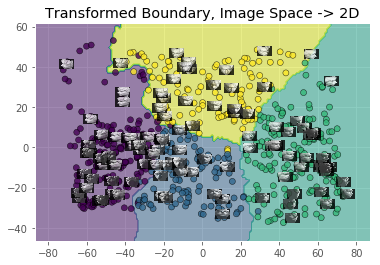

In [9]:
plot_2d_boundary(knn, X_train, Y_train, X_test, Y_test)

After submitting your answers, experiment with using using PCA instead of ISOMap. Are the results what you expected? Also try tinkering around with the test/train split percentage from 10-20%. Notice anything?

In [10]:
# Change Test_PCA = True
# and RUN ALL AGAIN